![logo](./img/LogoLine_horizon_CAMS.png)

| | | |
|:-:|:-:|:-:|
|[![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training/HEAD?urlpath=lab/tree/CAMS_atmospheric-composition.ipynb)|[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training/blob/master/CAMS_atmospheric-composition.ipynb)|[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-projects/copernicus-training/blob/master/CAMS_atmospheric-composition.ipynb)|

# Create Animations from CAMS Data

This tutorial demonstrates how to create animations from data of the [Copernicus Atmosphere Monitoring Service (CAMS)](https://atmosphere.copernicus.eu/).

In [1]:
!pip install cdsapi

In [18]:
# Import functions to interact with operating system 
import os

# Import CDS API
import cdsapi

# Library to extract data
from zipfile import ZipFile

# Libraries for reading and working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries to assist with animation and visualisations
%matplotlib inline
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib import animation
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import imageio
from IPython.display import clear_output
from IPython.display import HTML
import time

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

## Access data

Copy your API key into the code cell below, replacing `#######` with your key. (Remember, to access data from the ADS, you will need first to register/login https://ads.atmosphere.copernicus.eu and obtain an API key from https://ads.atmosphere.copernicus.eu/api-how-to.)

In [2]:
URL = 'https://ads.atmosphere.copernicus.eu/api/v2'

# Replace the hashtags with your key:
KEY = '3607:d358beb0-7701-48bb-b0d8-dd6947ab80fe'

Here we specify a data directory into which we will download our data and all output files that we will generate:

In [19]:
DATADIR = './DATA'

For our first plotting example, we will use CAMS Global Atmospheric Composition Forecast data. The code below shows the subset characteristics that we will extract from this dataset for the purpose of this tutorial as an API request.

```{note}
Before running this code, ensure that you have **accepted the terms and conditions**. This is something you only need to do once for each CAMS dataset. You will find the option to do this by selecting the dataset in the ADS, then scrolling to the end of the *Download data* tab.
```

In [5]:
c = cdsapi.Client(url=URL, key=KEY)
c.retrieve(
    'cams-global-atmospheric-composition-forecasts',
    {
        'variable': 'organic_matter_aerosol_optical_depth_550nm',
        'date': '2021-08-01/2021-08-08',
        'time': [
            '00:00', '12:00',
        ],
        'leadtime_hour': '0',
        'type': 'forecast',
        'area': [
            90, -180, 0,
            180,
        ],
        'format': 'netcdf_zip',
    },
    f'{DATADIR}/2021-08_AOD.zip')

2022-07-26 13:34:03,355 INFO Welcome to the CDS
2022-07-26 13:34:03,361 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-atmospheric-composition-forecasts
2022-07-26 13:34:03,426 INFO Request is queued
2022-07-26 13:34:04,497 INFO Request is running
2022-07-26 13:34:11,806 INFO Request is completed
2022-07-26 13:34:11,808 INFO Downloading https://download-0002-ads-clone.copernicus-climate.eu/cache-compute-0002/cache/data6/adaptor.mars_constrained.external-1658838815.9841146-4832-4-ab0a796c-7bab-42c1-9834-746170026e20.zip to ./DATA/2021-08_AOD.zip (6.2M)
2022-07-26 13:34:12,527 INFO Download rate 8.7M/s                                                                      


Result(content_length=6514604,content_type=application/zip,location=https://download-0002-ads-clone.copernicus-climate.eu/cache-compute-0002/cache/data6/adaptor.mars_constrained.external-1658838815.9841146-4832-4-ab0a796c-7bab-42c1-9834-746170026e20.zip)

## Read data

First we extract the downloaded zip file:

In [20]:
# Create a ZipFile Object and load zip file in it
with ZipFile(f'{DATADIR}/2021-08_AOD.zip', 'r') as zipObj:
   # Extract all the contents of zip file into a directory
   zipObj.extractall(path=f'{DATADIR}/2021-08_AOD/')

For convenience, we create a variable with the name of our downloaded file:

In [21]:
fn = f'{DATADIR}/2021-08_AOD/data.nc'

Now we can read the data into an xarray *Dataset*, then into a *Data Array*:

In [22]:
# Create Xarray Dataset
ds = xr.open_dataset(fn)
ds

<xarray.Dataset>
Dimensions:    (longitude: 900, latitude: 226, time: 16)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.6 -179.2 ... 178.8 179.2 179.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... 1.2 0.8 0.4 -2.033e-13
  * time       (time) datetime64[ns] 2021-08-01 ... 2021-08-08T12:00:00
Data variables:
    omaod550   (time, latitude, longitude) float32 ...
    aod550     (time, latitude, longitude) float32 ...
    duaod550   (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-06-21 18:56:30 GMT by grib_to_netcdf-2.24.3: /opt/ecmw...

In [23]:
# Create Xarray Data Array
da = ds['omaod550']

## Animations

To visualise the temporal dimension of this data we will create animations, with each frame corresponding to a time step. These include 00:00 and 12:00 at each day from 1 to 8 August. There are several ways to create animations. We will explore two possibilities: In the first example we will simply redraw each frame, and save the output to separate image files from which we will create an animated gif; in the second example we will generate an HTML5 video. 

### Animated gif

Here we will create an animated gif. This is quite a simple and robust method that works across all platforms. We will first view and save each frame of the animation, then combine the output images into an animated gif image.

#### View and save each frame

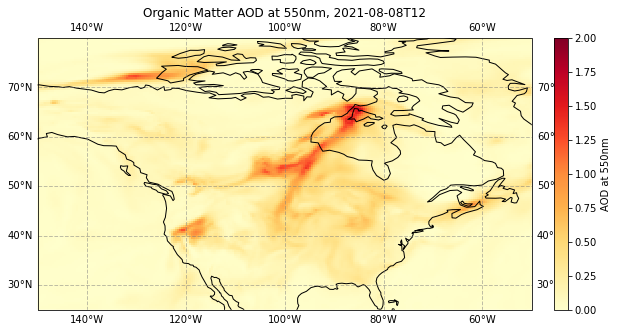

In [8]:
filenames = [] # Define an empty list of filenames
n = da.time.shape[0] # Number of frames in animation (= number of time-steps)

for i in range(n):
    fig = plt.figure(figsize=(10, 5)) # Define the figure and specify size
    ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree()) # Specify plot area & projection
    ax.set_extent([-150,-50,25,80], crs=ccrs.PlateCarree()) # Specify geographical extent
    ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') # Add lat/lon grid
    ax.set_title(f'Organic Matter AOD at 550nm, {str(da.time[i].values)[:-16]}', fontsize=12) # Set figure title
    im = plt.pcolormesh(da.longitude, da.latitude, da[i,:,:], cmap='YlOrRd', vmin=0, vmax=2) # Plot the data, iterating over time
    ax.coastlines(color='black') # Add coastlines
    
    cbar = plt.colorbar(im,fraction=0.046, pad=0.04) # Specify the colourbar
    cbar.set_label('AOD at 550nm') # Define the colourbar label

    filename = f'{DATADIR}/OMAOD_{str(da.time[i].values)[:-16]}.png' # Define a filename for each frame, in PNG format
    fig.savefig(filename) # Save the frame as a PNG file
    filenames.append(filename) # Append the frame to a list, to later create an animated gif
 
    plt.show() # Display the figure
    time.sleep(0.01) # Specify time delay for each iteration (frame) of the animation
    clear_output(wait=True) # Clear the output (figure) before the next iteration (frame) of the animation

The animation clearly shows the high values of total aerosol optical depth which appear to originate from the many wildfires burning across North America in this period. This includes the Dixie fire, which, by August 6, had grown to become the largest single (i.e. non-complex) wildfire in California's history, and the second-largest wildfire overall. 

The animation also shows these high values crossing the continent to the east coast where it still affects local air quality.

#### Save animated gif

In [13]:
# Save the animation as an animated GIF

with imageio.get_writer(f'{DATADIR}/OMAOD_Animated.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

### HTML5 video

In this example we will explore a different method to create animations. We will use matplotlib's *animation* function, and Jupyter's *HTML* function to play a video of the animation and provide the option to save as MP4.

```{note}
This requires FFmpeg, which can be tricky to use on Windows systems.
```

#### Create the animation

The animation function consists of 4 parts:
- **Setting the initial state:**<br>
 Here, you define the general plot your animation shall use to initialise the animation. You can also define the number of frames (time steps) your animation shall have.
 
 
- **Functions to animate:**<br>
 An animation consists of three functions: `draw()`, `init()` and `animate()`. `draw()` is the function where individual frames are passed on and the figure is returned as image. In this example, the function redraws the plot for each time step. `init()` returns the figure you defined for the initial state. `animate()` returns the `draw()` function and animates the function over the given number of frames (time steps).
 
 
- **Create a `animate.FuncAnimation` object:** <br>
 The functions defined before are now combined to build an `animate.FuncAnimation` object.
 
 
- **Play the animation as video:**<br>
 As a final step, you can integrate the animation into the notebook with the `HTML` class. You take the generate animation object and convert it to a HTML5 video with the `to_html5_video` function

In [7]:
# Set the initial state. 
# Here we create the figure, axes and plot the first frame of the animation:

fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_title('AOD at 550nm' + str(da.time[0].values)[:-10]+'\n', fontsize=18)
im = plt.pcolormesh(da.longitude, da.latitude, da[0,:,:], cmap='YlOrRd', vmin=0, vmax=2)
ax.set_extent([-150,-50,25,80], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.coastlines(color='black')
cbar = plt.colorbar(im,fraction=0.046, pad=0.05)
cbar.set_label('AOD at 550nm', fontsize=14)

frames = 16 # Number of frames in animation, i.e. number of time steps:

# Functions to create the animation

# Draw individual frame as image
def draw(i):
    img = plt.pcolormesh(da.longitude, da.latitude, da[i,:,:], cmap='YlOrRd', vmin=0, vmax=2)
    ax.set_title('AOD at 550nm ' + str(da.time[i].data)[:-10], fontsize=18, pad=20.0)
    ax.coastlines(color='black')
    return img

# Create the initial state of the figure
def init():
    return fig

# Return the draw function and animate over given frames
def animate(i):
    return draw(i)

# Calls the animation. 16 frames, 500 ms per frame. 
# blit set to false does not only re-draw parts which have changed
ani = animation.FuncAnimation(fig, animate, frames, interval=500, blit=False,
                              init_func=init, repeat=True)

# Convert animation object to HTML5 video
HTML(ani.to_html5_video())
plt.close(fig)

In [15]:
# Set the initial state. 
# Here we create the figure, axes and plot the first frame of the animation:

fig = plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
ax.set_title('AOD at 550nm' + str(da.time[0].values)[:-10]+'\n', fontsize=18)
im = plt.pcolormesh(da.longitude, da.latitude, da[0,:,:], cmap='YlOrRd', vmin=0, vmax=2)
ax.set_extent([-150,-50,25,80], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
ax.coastlines(color='black')
cbar = plt.colorbar(im,fraction=0.046, pad=0.05)
cbar.set_label('AOD at 550nm', fontsize=14)

frames = 16 # Number of frames in animation, i.e. number of time steps:

# Functions to create the animation

# Draw individual frame as image
def draw(i):
    img = plt.pcolormesh(da.longitude, da.latitude, da[i,:,:], cmap='YlOrRd', vmin=0, vmax=2)
    ax.set_title('AOD at 550nm ' + str(da.time[i].data)[:-10], fontsize=18, pad=20.0)
    ax.coastlines(color='black')
    return img

# Return the draw function and animate over given frames
def animate(i):
    return draw(i)

# Calls the animation. 16 frames, 500 ms per frame. 
# blit set to false does not only re-draw parts which have changed
ani = animation.FuncAnimation(fig, animate, frames, interval=500, blit=False,
                              repeat=True)

# Convert animation object to HTML5 video
HTML(ani.to_html5_video())
plt.close(fig)

<br>

#### Play the animation as HTML5 video

In [16]:
HTML(ani.to_html5_video())

### Other way to create animations

In [ ]:
c = cdsapi.Client(url=URL, key=KEY)
c.retrieve(
    'cams-global-reanalysis-eac4',
    {
        'variable': 'total_column_ozone',
        'date': '2020-07-01/2021-01-31',
        'time': '00:00',
        'format': 'netcdf',
        'area': [
            0, -180, -90,
            180,
        ],
    },
    f'{DATADIR}/TCO3_202007-202101_SHem.nc')

In [9]:
fn = f'{DATADIR}/TCO3_202007-202101_SHem.nc'
ds = xr.open_dataset(fn)
ds

<xarray.Dataset>
Dimensions:    (longitude: 480, latitude: 121, time: 215)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.2 -178.5 ... 177.8 178.5 179.2
  * latitude   (latitude) float32 0.0 -0.75 -1.5 -2.25 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 2020-07-01 2020-07-02 ... 2021-01-31
Data variables:
    gtco3      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-08-29 07:48:48 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [10]:
da = ds['gtco3']

In [11]:
fig = plt.figure(figsize=(5, 5)) 
ax = plt.subplot(1,1,1, projection=ccrs.Orthographic(central_latitude=-90)) 
ax.coastlines(color='black') # Add coastlines
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
ax.set_title(f'Total Column Ozone, {str(da.time[0].values)[:-19]}', fontsize=12) 
im = plt.pcolormesh(da.longitude.values, da.latitude.values, da[0,:,:],
                cmap='jet', transform=ccrs.PlateCarree(), vmin=0, vmax=0.01)
cbar = plt.colorbar(im,fraction=0.046, pad=0.04) 
cbar.set_label('Total Column Ozone') 

frames = 3

def animate(i):
    array = da[i,:,:].values
    im.set_array(array.flatten())
    ax.set_title(f'Total Column Ozone, {str(da.time[i].values)[:-19]}', fontsize=12)

ani = animation.FuncAnimation(fig, animate, frames, interval=100)
#ani.save(f'{DATADIR}/TCO3_test.gif')

plt.close()
#HTML(ani.to_html5_video())
HTML(ani.to_jshtml())

#### Piece by piece

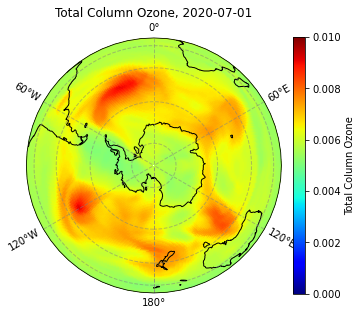

In [12]:
fig = plt.figure(figsize=(5, 5)) 
ax = plt.subplot(1,1,1, projection=ccrs.Orthographic(central_latitude=-90)) 
ax.coastlines(color='black') # Add coastlines
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
ax.set_title(f'Total Column Ozone, {str(da.time[0].values)[:-19]}', fontsize=12) 
im = plt.pcolormesh(da.longitude.values, da.latitude.values, da[0,:,:],
                cmap='jet', transform=ccrs.PlateCarree(), vmin=0, vmax=0.01)
cbar = plt.colorbar(im,fraction=0.046, pad=0.04) 
cbar.set_label('Total Column Ozone') 

In [13]:
frames = 50

In [14]:
def animate(i):
    array = da[i,:,:].values
    im.set_array(array.flatten())
    ax.set_title(f'Total Column Ozone, {str(da.time[i].values)[:-19]}', fontsize=12)

In [15]:
ani = animation.FuncAnimation(fig, animate, frames, interval=100)
#ani.save(f'{DATADIR}/TCO3_test.gif')

In [16]:
HTML(ani.to_html5_video())

In [17]:
HTML(ani.to_jshtml())